In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import json
import sys
import numpy as np
from scipy.stats import kurtosis, norm
from scipy.special import logsumexp
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm, trange
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp

sys.path.append('../scripts/python')
from parameter_estimation import BivariateBeta
from experiments import starting_experiment, starting_experiment_2

plt.style.use('science')

from autograd import grad
import autograd.numpy as np

## Second diagnostic

Presenting the use of method delta:

In [4]:
def h(x):   
    aux = x[2] * np.exp(0.5*(np.log(x[0]) + np.log1p(-x[0]) + np.log(x[1]) + np.log1p(-x[1])))
    v = np.array([aux + x[0]*x[1], aux + x[0]*(1-x[1]), aux + x[1]*(1-x[0]), aux + (1-x[0])*(1-x[1])])
    return np.prod(v)

grad_h = grad(h)

def matrix(x,y,D):
    Lambda = np.zeros((3,3))
    Lambda[:-1,:-1] = D*np.cov(x,y)
    Lambda[0,2] = Lambda[2,0] = np.sqrt(D)*np.cov(x, (x-x.mean())*(y-y.mean()))[0,1]
    Lambda[1,2] = Lambda[2,1] = np.sqrt(D)*np.cov(y, (x-x.mean())*(y-y.mean()))[0,1]
    Lambda[2,2] = np.var((x-x.mean())*(y-y.mean()))
    return Lambda

When $n=50$, it does not converge. 

In [7]:
true_alpha = np.array([2,1,1,1])
n = 50

m1, m2, v1, v2, rho = BivariateBeta(true_alpha).moments()
moments_true = np.array([m1,m2,rho])
derivative = grad_h(moments_true)
mean = h(moments_true)
v = []
for i in range(10000):
    U = np.random.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    moments_hat = np.array([X.mean(), Y.mean(), np.corrcoef(X,Y)[0,1]])
    #D = v1*v2
    #Lambda = matrix(X,Y,D)
    v.append(np.sqrt(n) * (h(moments_hat) - mean))#/np.sqrt(derivative @ Lambda @ derivative))

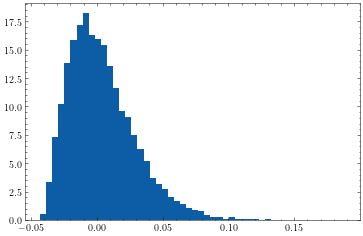

In [8]:
plt.hist(v, bins=50, density=True)
#t = np.linspace(-4,4,2000)
#plt.plot(t, norm(0, 1).pdf(t), color='black')
plt.show()

With $n=1000$

In [18]:
true_alpha = np.array([2,1,1,1])
n = 500

m1, m2, v1, v2, rho = BivariateBeta(true_alpha).moments()
moments_true = np.array([m1,m2,rho])
derivative = grad_h(moments_true)
mean = h(moments_true)
v = []
for i in range(10000):
    U = np.random.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    moments_hat = np.array([X.mean(), Y.mean(), np.corrcoef(X,Y)[0,1]])
    #D = v1*v2
    #Lambda = matrix(X,Y,D)
    v.append(np.sqrt(n) * (h(moments_hat) - mean))#/np.sqrt(derivative @ Lambda @ derivative))

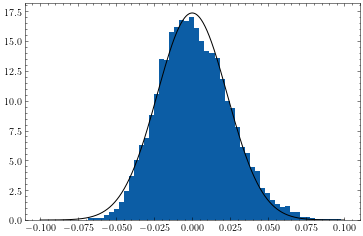

In [19]:
plt.hist(v, bins=50, density=True)
t = np.linspace(-0.1,0.1,2000)
plt.plot(t, norm(0, 0.023).pdf(t), color='black')
plt.show()

## That's not good because...

In [31]:
rng = np.random.default_rng(671289)
n = 50

Z = rng.multivariate_normal(mean=[1,1], cov=[[1,-0.6],[-0.6,1]], size=n)
X = 1/(1+np.exp(-Z[:,0]))
Y = 1/(1+np.exp(-Z[:,1]))

P_values = []

for i in range(500):
    indeces = np.random.choice(range(n), size=n)
    Xb = X[indeces]
    Yb = Y[indeces]
    m1 = np.mean(Xb)
    m2 = np.mean(Yb)
    rho = np.corrcoef(Xb, Yb)[0,1]
    D = rho * np.exp(0.5*(np.log(m1) + np.log1p(-m1) + np.log(m2) + np.log1p(-m2)))
    P = min(D + m1*m2, -D + m1*(1-m2), -D + m2*(1-m1), D + (1-m1)*(1-m2))
    P_values.append(P)

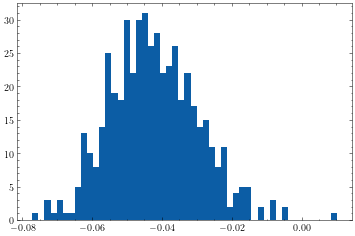

In [32]:
plt.hist(P_values, bins=50)
plt.show()